In [1]:
!pip install boto3

  Using cached boto3-1.21.46-py3-none-any.whl (132 kB)
  Using cached jmespath-1.0.0-py3-none-any.whl (23 kB)
  Using cached botocore-1.24.46-py3-none-any.whl (8.7 MB)
  Using cached s3transfer-0.5.2-py3-none-any.whl (79 kB)


In [2]:
!pip install astropy

  Using cached astropy-5.0.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (11.1 MB)
  Using cached pyerfa-2.0.0.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (742 kB)


In [3]:
!pip install sfdmap

  Using cached sfdmap-0.1.1-py3-none-any.whl


In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'git')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')
s3_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V2')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

In [5]:
# loading the table
final_table_csv_path = os.path.join(endpoint_url,bucket_name,s3_final_table_csv_path)
gs = pd.read_csv(final_table_csv_path, header = 0, dtype = {
    'specobjid' : str,
    'z' : float,
    'z_noqso' : float,
    'snMedian' : float,
    'run2d' : str,
    'ra' : float,
    'dec' : float,
    'plate' : int,
    'mjd' : int,
    'fiberid' : int,
    'waveMin' : float,
    'waveMax' : float
    })
print('Total galaxies in DR16: %d' % len(gs))

Total galaxies in DR16: 3234563


In [6]:
cnt = len(gs)
total_filtered = 0

In [7]:
# parameters
snr_th = 0.6
z_th = 0.03

In [8]:
# Remove galaxies with low redshift
gs = gs[gs.z > z_th]
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print('Total galaxies filtered with low z values: %d' % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered with low z values: 94412


In [9]:
# Remove galaxies with low SNR
gs = gs[gs.snMedian > snr_th]
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print('Total galaxies filtered with low snr values: %d' % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered with low snr values: 172465


In [10]:
wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_dir_path,'wl_grid.npy'))

loading from uri: s3://tau-astro/almogh/workdir3/data/wl_grid.npy


In [11]:
# adding Dalya's scores
dalya_scores_URL = 'http://wise-obs.tau.ac.il/~dovip/weird-galaxies/full.csv'
dalya_df = pd.read_csv(dalya_scores_URL)
dalya_df = dalya_df.rename(columns={" mjd":"mjd"," fiber":"fiberid", " weirdness":"weirdness"})
gs = gs.merge(dalya_df, how='inner', on=['plate', 'mjd', 'fiberid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with Dalya's scores: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with Dalya's scores: 969726


In [12]:
galSpecInfo = pd.read_csv(os.path.join(endpoint_url, bucket_name, s3_data_dir_path, 'galSpecInfo.csv'), header = 0, dtype = {
    'specobjid' : str,
    'plateid' : int,
    'mjd' : int,
    'fiberid' : int,
    'spectrotype' : str,
    'subclass' : str
    })

In [13]:
galSpecInfo = galSpecInfo.rename(columns={"plateid":"plate"})
gs = gs.merge(galSpecInfo, how='inner', on=['specobjid', 'plate', 'mjd', 'fiberid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with galSpecInfo: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with galSpecInfo: 1267075


In [14]:
galSpecLine = pd.read_csv(os.path.join(endpoint_url, bucket_name, s3_data_dir_path, 'galSpecLine.csv'), header = 0, dtype = {
    'specobjid' : str,
    'oii_3726_eqw' : float,
    'oii_3729_eqw' : float,
    'neiii_3869_eqw' : float,
    'h_delta_eqw' : float,
    'h_gamma_eqw' : float,
    'oiii_4363_eqw' : float,
    'h_beta_eqw' : float,
    'oiii_4959_eqw' : float,
    'oiii_5007_eqw' : float,
    'hei_5876_eqw' : float,
    'oi_6300_eqw' : float,
    'nii_6548_eqw' : float,
    'h_alpha_eqw' : float,
    'nii_6584_eqw' : float,
    'sii_6717_eqw' : float,
    'sii_6731_eqw' : float,
    'ariii7135_eqw' : float
    })

In [15]:
gs = gs.merge(galSpecLine, how='inner', on=['specobjid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with galSpecLine: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with galSpecLine: 0


Text(0.5, 0, 'SNR')

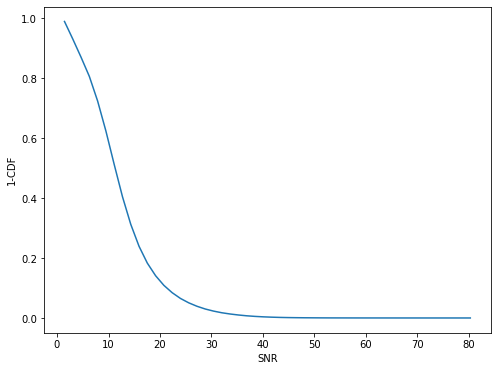

In [16]:
# ploto SNR histogram

hist, bin_edges = np.histogram(gs.snMedian, bins=50)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
pdf = hist/hist.sum()
cdf = np.cumsum(pdf)

from matplotlib.widgets import Cursor
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bin_centers, 1-cdf)
ax.set_ylabel('1-CDF')
ax.set_xlabel('SNR')

In [17]:
print('Total number of galaxies left: %d' % len(gs))

Total number of galaxies left: 730885


In [18]:
print('Estimated dataset size: %.1fGB' % (len(gs)*len(wl_grid)*4/1024/1024/1024))

Estimated dataset size: 43.8GB


In [24]:
# save the dataframe in parts
N = 8
splits = np.linspace(0,len(gs),N+1).astype(int)
for i in range(N):
    print("saving gs{0} for rows {1}-{2}".format(i,splits[i],splits[i+1]))
    to_s3_pkl(gs[splits[i]:splits[i+1]], s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs{0}.pkl'.format(i)))

saving gs0 for rows 0-91360
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs0.pkl
saving gs1 for rows 91360-182721
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs1.pkl
saving gs2 for rows 182721-274081
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs2.pkl
saving gs3 for rows 274081-365442
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs3.pkl
saving gs4 for rows 365442-456803
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs4.pkl
saving gs5 for rows 456803-548163
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs5.pkl
saving gs6 for rows 548163-639524
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs6.pkl
saving gs7 for rows 639524-730885
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs7.pkl
